In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import networkx as nx
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter
import math
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
%matplotlib inline

## Cora dataset

The Cora dataset is the MINST equivalent for the graph representation learning problem. It consists of about 3000 papers, divided into 7 classes. The citation network has more than 5000 links. For more information, visit [this site](https://graphsandnetworks.com/the-cora-dataset/).

![cora image](https://graphsandnetworks.com/wp-content/uploads/2019/09/CoraBalloons.png)

## Load and process the graph

In [2]:
cora = pd.read_csv(
  "./cora/cora.cites",
  sep="\t",
  header=None,
  names=["target", "source"]
)

feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  ["node_id"] + feature_names + ["subject"]
node_data = pd.read_csv(
  "cora/cora.content",
  sep='\t',
  header=None,
  names=column_names
)

node_data = node_data[["node_id", "subject"]].drop_duplicates()

In [3]:
node_data["node_id"].nunique()

2708

In [4]:
cora.sample(n=5)

,target,source
2801,33818,78552
959,4329,510718
2653,28504,7430
672,2665,763009
5281,648112,648121


In [5]:
G = nx.from_pandas_edgelist(cora)

In [6]:
print("N. edges", G.number_of_edges())
print("N. nodes", G.number_of_nodes())

N. edges 5278
N. nodes 2708


In [7]:
attrs = {
  row[1]: {"subject": row[2]}
  for row in node_data.itertuples()
}

In [8]:
nx.set_node_attributes(G, attrs)

## Random walk generation

We implement a first-order random walk algorithm. That is, we sample each node according to a uniform probability distribution between the node's neighboors. **Note**: this algorithm is far from optimal; we can speed the computation up by creating a probability transaction matrix to sample from.

In [9]:
def random_walk(
  G: nx.Graph,
  starting_node: int,
  walk_length: int,
  p: float = 1,
  q: float = 2,
) -> list[int]:
  """Compute a random walk of length `walk_length`, staring from
  node `starting_node` of graph `G`
  
  Args:
    G: the graph to use to perform the walk
    starting_node: the node at which the walk starts
    walk_length: how many node to sample from the graph
    p: return parameter, controls the likelihood of visiting
      an already-visited node
    q: in-out parameter, controls the probability of visiting
      the last neighborhood
  
  Returns:
    The performed random walk
  """
  def compute_alpha(dist, p, q):
    if dist == 1:
      return 1
    elif dist == 0:
      return 1/p
    else:
      return 1/q
  
  walk = [starting_node]
  last_node = starting_node

  for _ in range(walk_length):
    neighbors = list(G.neighbors(starting_node))
    # Bias the serch according to 2-order random walk (node2vec)
    probs = np.ones(len(neighbors))
    alpha = np.array([
      compute_alpha(nx.shortest_path_length(G, last_node, neighbor), p, q)
      for neighbor in neighbors
    ])
    probs *= alpha
    probs /= probs.sum()
    
    last_node = starting_node
    starting_node = neighbors[np.random.multinomial(1, probs).argmax()]
    
    walk.append(starting_node)

  return walk

In [12]:
random_walk(G, 1033, 20, p=2, q=0.5)

[1033,
 1107062,
 61069,
 1129610,
 210872,
 35,
 44368,
 1128227,
 577331,
 647447,
 8874,
 1153816,
 61069,
 1129610,
 210872,
 210871,
 59715,
 54131,
 1153897,
 94641,
 594387]

## Node2vec

The Node2Vec model is a two-step process: Random Walk + SkipGram. Ideally, the random walks represent the "corpus" of our graph, while SkipGram tries to predict the context window given a source node.

The vocabulary is formed by graph nodes, while the corpus is composed by random walks.

In [27]:
walk_len = 5
n_walk = 5  # How many times to perform random walk on the same starting node
p = 2  # Control how like we are in sampling further away nodes
q = 0.5  # Bias the search near last node (> 1) or current node (< 1)

In [28]:
%%time

vocabulary = list(map(lambda x: x[0], G.nodes().items()))
corpus = []

for _ in range(n_walk):
  corpus.extend([random_walk(G, i, walk_len, p, q) for i in vocabulary])
  
vocabulary_size = len(vocabulary)

CPU times: user 3.12 s, sys: 26 µs, total: 3.12 s
Wall time: 3.13 s


In [29]:
len(corpus)

13540

In [30]:
vocabulary_size

2708

In [31]:
assert len(corpus) == n_walk * len(vocabulary)

In [32]:
ntoi = {n: i for i, n in enumerate(vocabulary)}
iton = {v: k for k, v in ntoi.items()}

In [33]:
# Convert each node into and index
corpus = list(map(lambda walk: [ntoi[node] for node in walk], corpus))

In [34]:
from typing import List, Optional, Dict

class ContextGenerator(Dataset):
  """Generate a custom dataset to train SkipGram with negative sampling strategy."""
  def __init__(
    self,
    random_walks: List[List[int]],
    window_size: int = 2,
    subsample_threshold: float = 0.0,
    negative_examples: int = 0,
  ):
    """Construct the dataset for SkipGram
    
    Args:
      random_walks: the list of random walks to use as corpus
      window_size: the size of the context window
      subsample_threshold: the threshold to use to subsample frequent nodes
      negative_examples: how many negative context nodes to generate
    """
    self.subsample_threshold = subsample_threshold
    self.negative_examples = negative_examples
    self.window_size = window_size
    self.dataset = []

    # Init the downsampling probabilities
    freqs = Counter([node for walk in random_walks for node in walk])
    total_nodes = sum(freqs.values())
    self._freqs_normalized = {
      node: freq / total_nodes
      for node, freq in freqs.items()
    }
    
    # Init the negative sampling probabilities
    self._negative_probabilites = torch.tensor(
      list(self._freqs_normalized.values()), dtype=torch.float32)
     
    # Create the dataset
    for walk in random_walks:
      walk = [node for node in walk if random.random() < self._get_prob(node)]
      # Create the context window
      for center_idx in range(len(walk)):
        for w in range(-window_size, window_size + 1):
          context_idx = center_idx + w
          if context_idx < 0 or context_idx >= len(walk) or center_idx == context_idx:
            continue
          self.dataset.append((walk[center_idx], walk[context_idx]))
  
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    center, context = self.dataset[idx]
    if self.negative_examples > 0:
      negative_context = torch.multinomial(
        self._negative_probabilites, self.negative_examples, replacement=True)
      return center, context, negative_context
    
    return center, context
  
  def _get_prob(self, node) -> float:
    return (
      math.sqrt(self._freqs_normalized[node] / self.subsample_threshold) 
      + 1) * (self.subsample_threshold / self._freqs_normalized[node])

In [35]:
# Create training set

training_set = ContextGenerator(
  corpus,
  window_size=2,
  subsample_threshold=0.001,
  negative_examples=10,
)
training_dataloader = DataLoader(training_set, batch_size=32, shuffle=True)

In [36]:
len(training_set)

238632

## Skipgram

In [37]:
class SkipGram(nn.Module):
  """The SkipGram model with a negative sampling forward strategy."""
  def __init__(
    self,
    vocabulary_size: int,
    embedding_dim: int,
  ):
    """Construct the SkipGram model.
    
    Args:
      vocabulary_size: the size of the vocabulary (i.e., the total number
        of nodes to embed)
      embedding_dim: the embedding dimension (i.e., the latent space
        dimension)
    """
    super(SkipGram, self).__init__()
    self.node_embedding = nn.Embedding(
      vocabulary_size, embedding_dim, dtype=torch.float32)
    self.context_embedding = nn.Embedding(
      vocabulary_size, embedding_dim, dtype=torch.float32)
#     self.context = nn.Linear(embedding_dim, vocabulary_size, bias=False)

  def forward(self, center, context, negative_context=None):
    """Compute the forward pass of SkipGram.
    
    **Note** that this implementation differs from the classical
    one since here we exploit the speed-up introduced by the negative
    sampling loss. That is, we do not perform a dot product between
    all the context embedding weights, but only on the specified subset.
    This leads to fewer backward updates and faster convergence.

    Args:
      center: the center nodes (shape batch_size)
      context: the context nodes (shape batch_size)
      negative_context: the negative context nodes (with shape batch_size * num_negative)
      
    Returns:
      The true_logits if `negative_context` is None, otherwise a tuple with
      (true_logits, negative_logits)
    """
    true_score = (
      self.node_embedding(center) * self.context_embedding(context)
    ).sum(-1)
    
    if negative_context is not None:
      false_score = torch.bmm(
        self.context_embedding(negative_context), self.node_embedding(center).unsqueeze(-1)
      ).squeeze()
      return true_score, false_score
    
    return true_score

  def embed(self, node):
    """Return the embedding of the node:
    
    Args:
      node: the node index (should be a Long torch Tensor)
      
    Returns:
      The embedding of the node as a torch Tensor.
    """
    return self.node_embedding(node)

In [38]:
def nce_loss(true_logits, negative_logits):
  """Compute the Negative Contrastive Loss.
  
  This is an ad hoc version of the actual NCE loss, since
  we take as input the already computed logits as separate
  instances, instead of the logits and the labels.
  
  Args:
    true_logits: tensor of the computed true context logits
    negative_logits: tenors of the computed negative context logits
  
  Returns:
    The loss computed from the input logits.
  """
  true_loss = F.logsigmoid(true_logits)
  neg_loss = F.logsigmoid(-negative_logits).sum(-1)
  return -(true_loss+neg_loss).mean()

In [39]:
# Construct the model and training parameters

embedding_dims = 20

model = SkipGram(vocabulary_size, embedding_dims)

sgd = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(sgd, step_size=10, gamma=0.8)
criterion = nce_loss

In [40]:
%%time

# Training
num_epochs = 10

for epoch in range(num_epochs):
  loss_val = 0

  for batch, (center, context, negative_context) in enumerate(training_dataloader):    
    # True score value
    true_logits, neg_logits = model(center, context, negative_context)
    loss = criterion(true_logits, neg_logits)
#     loss = F.cross_entropy(logits, context)
    loss_val += loss.item()

    # Backward
    sgd.zero_grad()
    loss.backward()
    sgd.step()

  # Update the learning rate
  scheduler.step()

  # Print
  if epoch % 1 == 0:
    print(f"[{epoch:5}] Loss: {loss_val/batch}, lr={scheduler.get_last_lr()}")

[    0] Loss: 5.334883353114527, lr=[0.1]
[    1] Loss: 1.4138648457304632, lr=[0.1]
[    2] Loss: 0.8675151683257255, lr=[0.1]
[    3] Loss: 0.6744125913671247, lr=[0.1]
[    4] Loss: 0.5860513138282678, lr=[0.1]
[    5] Loss: 0.5383589948394255, lr=[0.1]
[    6] Loss: 0.5059423486560891, lr=[0.1]
[    7] Loss: 0.4857367516349288, lr=[0.1]
[    8] Loss: 0.46856335957595935, lr=[0.1]
[    9] Loss: 0.4571576683502407, lr=[0.08000000000000002]
CPU times: user 50min 51s, sys: 3.6 s, total: 50min 55s
Wall time: 3min 38s


In [41]:
# Visualization
tsne = TSNE(perplexity=50)
out = tsne.fit_transform(model.node_embedding.weight.detach().numpy())

Text(0.5, 1.0, 'TSNE embedding of Node2Vec SkipGram')

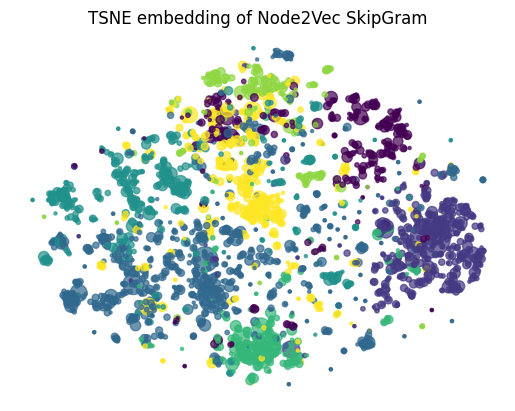

In [43]:
_, colors = np.unique([G.nodes[i]["subject"] for i in vocabulary], return_inverse=True)
plt.scatter(
  out[:, 0],
  out[:, 1],
  c=colors,
  s=[G.degree[i] * 5 for i in vocabulary],
  alpha=0.7,
);
plt.axis("off");
plt.title("TSNE embedding of Node2Vec SkipGram")

## Task: node label prediction

Given the computed embedding, can we predict the topic of the paper?

A more intresting problem could be predict if two papers should be linked (that is, if a paper should have cited another one). To perform this kind of prediction, we need two things: an edge embedding layer (which combine two node representations into a single representation) and a train/test split strategy that preserves connectivity in the graph. Since creating a split strategy that preserve graph connectivity (and also sample negative edges) is quite complext, we resort to the more simple task of node label prediction.

In [199]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import zero_one_loss, confusion_matrix

In [123]:
label = [G.nodes[n]["subject"] for n in vocabulary]

In [124]:
ohe = LabelEncoder()
label = ohe.fit_transform(label)

In [200]:
label[:10]

array([1, 1, 2, 1, 1, 1, 1, 1, 1, 1])

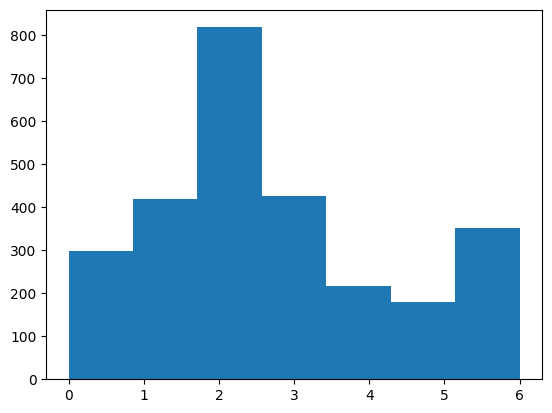

In [223]:
plt.hist(label, bins=7);

In [207]:
dataset = [
  model.embed(torch.tensor(ntoi[node], dtype=torch.long)).detach().numpy()
  for node in vocabulary
]

In [208]:
train_X, test_X, train_y, test_y = train_test_split(dataset, label, test_size=0.2)

In [209]:
len(train_X), len(test_X), len(train_y), len(test_y)

(2166, 542, 2166, 542)

In [226]:
lr = RandomForestClassifier(
  n_estimators=50,
  max_depth=10,
  min_samples_leaf=5,
  n_jobs=4,
  random_state=23,
  class_weight="balanced",
)

In [227]:
lr = lr.fit(train_X, train_y)

In [228]:
zero_one_loss(train_y, lr.predict(train_X))

0.06555863342566948

In [229]:
pred = lr.predict(test_X)

In [230]:
zero_one_loss(test_y, pred)

0.2656826568265682

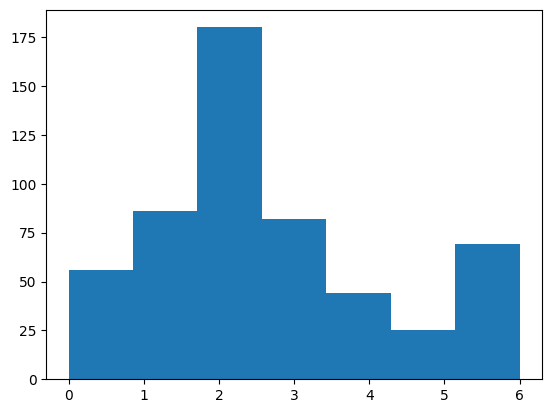

In [231]:
plt.hist(test_y, bins=7);

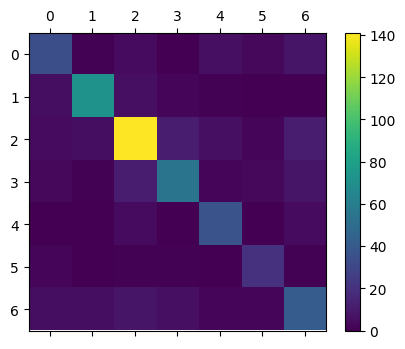

In [233]:
plt.matshow(confusion_matrix(test_y, pred));
plt.colorbar(shrink=0.8);